$\textbf{Anwendungen von Spectralem Clustering auf Beispieldatensätze} \\$ 
In diesem Abschnitt wollen wir untersuchen, wie der Wahl des Ähnlichkeitsgraphen mit ensprechenden Parametern unser Ergebnis beim Spectralen Clustering beeinflusst. Dazu erzeugen wir 2 verschiedene Datensätze und betrachten verschiedene Ähnlichkeitsgraphen mit unterschiedlichen Parametern. Der $k$-means Algorithmus hat mit beiden Datensätze Probleme, wie wir sehen werden. In diesem Notebook beginne wir mit dem ersten Beispieldatensatz.

Wir importieren zunächst alle notwendigen Bibliotheken.

In [1]:
#Wir implementieren zunächst alle nötigen Bibliotheken
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import radius_neighbors_graph
from sklearn.metrics.pairwise import euclidean_distances
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib




Die Algorithmen, die wir betrachten werden, gruppieren Punkte, indem sie jedem Punkt $X_i$ eine Zahl aus $\{0,1,...,k-1\}$ zuordnen und diese in einem Array speicheren, welchen wir über 'Algorithmusname'.labels_ aufrufen können. Diese Zuordnung ist unter Berücksichtigungen von Permutationen natürlich nicht eindeutig. Für $k=3$ Cluster gibt es beispielsweise $3! = 6$ verschiedene Möglichkeiten, die 3 Cluster mit jeweils mit einer eindeutigen Zahl zu identifizieren. Mit der folgenden Funktion erreichen wir deshalb, dass wir für unsere Beispieldatensätze bestehend aus jeweils 3 Gruppen jene der 6 Clusterzuordnung nehmen, die der Originallabelung am ähnlichsten ist. Dabei berechnen wir, jeweils die Anzahl der Elemente, die anders gelabelt sind als beim Original und nehmen jene Zuordnung, bei diese Anzahl am geringsten ist.

In [4]:
#Passe Clusterlabels so an, dass diese weitesgehend mit Original-labeling übereinstimmt
#Es gibt 6 verschiedene Möglichkeiten 3 Cluster mit den Zahlen {0,1,2} zu clusterfizieren

#Wir zählen dabei immer, wie viele Elemente bei welcher Variante falsch zugeordnet wurden und nehmen am Schluss
#die Variante, die der Originalzurdnung am besten entspricht

def beste_labelung (Original_label, cluster_label):
    
    #1. Varinate: Zuordnung wie vom Algorithmus zurückgegeben
    min = np.count_nonzero(Original_label - cluster_label)
    beste_label = cluster_label
    
    
    #2. Variante: 0->1, 1->2, 2->0:  
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=1 
    label_neu[label_neu == -1]=2
    label_neu[label_neu == -2]=0
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)
        
        
    #3. Variante: 0->1, 1->0, 2->2:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=1
    label_neu[label_neu == -1]=0
    label_neu[label_neu == -2]=2
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

    #4. Variante: 0->2, 1->0, 2->1:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=2
    label_neu[label_neu == -1]=0
    label_neu[label_neu == -2]=1
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

     #5. Variante: 0->2, 1->1, 2->0:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=2
    label_neu[label_neu == -1]=1
    label_neu[label_neu == -2]=0
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

    #6. Variante: 0->0, 1->2, 2->1:
    label_neu = -cluster_label     
    label_neu[label_neu ==  0]=0
    label_neu[label_neu == -1]=2
    label_neu[label_neu == -2]=1
    if np.count_nonzero(Original_label-label_neu) < min:
        beste_label = label_neu
        min = np.count_nonzero(Original_label-label_neu)

    return(min, beste_label)


Nun erzeugen wir unseren ersten Datensatz, wenden $k$-means auf diesen an und plotten die Ergebnisse. Der Datensatz besteht dabei aus zwei Monden und einem Blob. Als Monde bezeichnen wir zwei Punktmengen, bei denen die Punkte zunächst auf zwei ineinanderliegenden Halbkreisen liegen und dann für jeden dieser Punkte in beiden Dimensionen eine normalverteilte Zufallsvariable (ZV) mit Mittelwert $\mu = 0$ und Varianz $\sigma^2$ aufaddiert wird. Im Code entspricht "noise" diesem $\sigma$. Als Blob bezeichnen wir eine Menge von zweidimensional Normalverteilten ZVn mit Erwartungswertvektor $\mu \in \mathbb{R}^2$ und Kovarianzmatrix $\Sigma = \sigma^2  I_d \in \mathbb{R}^{2x2}$. Diesen Wert für $\sigma$ legen wir im Code mit "cluster_std" und den Wert für $\mu$ legen wir mit "centers" fest. Wenn wir hier $k$ Mittelpunkte $\mu_1, \dots, \mu_k \in \mathbb{R}^2$ festlegen, erzeugen wir $k$ Blobs mit den jeweiligen Mittelpunkten $\mu_1, \dots, \mu_k$ und der festlegeten Kovarianzmatrix.

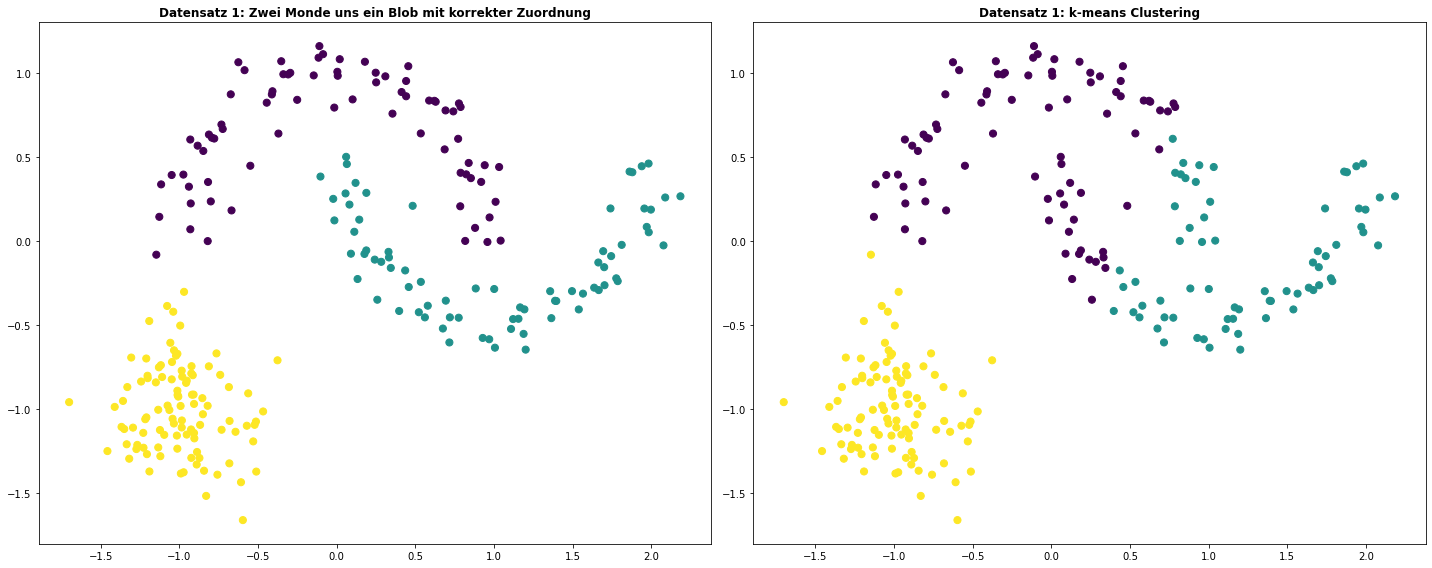

In [5]:
#Datensatz_1: Zwei Monde und ein Blob
Monde, y_1 = datasets.make_moons(150, noise=0.1, shuffle = False, random_state = 2) #erzeuge Monde
Blobs,y_2 = datasets.make_blobs(n_samples=100, centers = [[-1,-1]], cluster_std = 0.25, shuffle = False, random_state = 87) #erzeuge Blob
 

#Füge Mode und Blob zu einem Datensatz zusammen
Daten_1 = np.concatenate((Monde, Blobs), 0) 
Zugehörigkeit_1 =  np.concatenate((y_1, y_2+2), 0)

#Anzahl Datenpunkte 
n_1 = Daten_1.shape[0]


#Wende k-means auf den Datensatz an und plotte entsprechendes Clustering
km1 = KMeans(n_clusters=3)
km1.fit(Daten_1)
_, km_labels  = beste_labelung(Zugehörigkeit_1, km1.labels_)
#Plotte Datensatz mit korrekter Zugehörigkeit und mit k-means Clustering

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))

#Originalzugehörigkeit
ax[0].set_title('Datensatz 1: Zwei Monde uns ein Blob mit korrekter Zuordnung', fontsize=12, fontweight='demi')
ax[0].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 50, c =Zugehörigkeit_1 )

#k-means
ax[1].set_title('Datensatz 1: k-means Clustering', fontsize=12, fontweight='demi')
ax[1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 50, c= km_labels, cmap = 'viridis')

fig.tight_layout()

plt.show()

Wir sehen, dass $k$-means Probleme hat, die nicht konvexen Monde zu unterscheiden. Dagegen wird deutlich werden, dass wir mit der Spectralen Clusteranalyse nach geeigneter Wahl des Ähnlichkeitsgraphen und Parameter keine Probleme haben, die Cluster korrekt zu identifizieren. Dabei wollen wir auch den Einfluss der Wahl des Ähnlichkeitsgraphen und der entsprechenden Parameter beim Spectralen Clustering untersuchen: Als Algorithmus benutzen wir die Implementierung von sklearn/scikit-learn. Als Eingabeparameter geben wir die Anzahl der zu findenden Cluster ('n_clusters') und 'precomputed' beim Parameter 'affinity' an. Dies sorgt dafür, dass der Algorithmus unsere Eingabematrizen bereits als vorbereitete Ähnlichkeitsmatrizen betrachtet. 

In [23]:
#wir Erstellen Objekt der Klasse SpectralClustering, das wir für das Clustering mit kNN- und Epsilon-Graphen benutzen werden
SC_1 = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels= 'kmeans')


Zunächst erstellen wir einen $k$NN-Graphen für unseren Datensatz.
Dazu benutzen wir den kneighbors_graph von sklearn/scikit-learn, bei dem wir alle Punkte $x_i$ mit Punkten $x_j$ verbinden, wenn $x_j$ zu den $k$-nächsten Nachbarn von $x_i$ gehört. Als Rückgabewert erhalten wir eine Matrix $A$, die entweder eine einfache Adjazenzmatrix bestehend aus Nullen und Einsen oder eine gewichtete Adjazenzmatrix mit den Abständen $d_{ij} = \|x_i - x_j \|$ statt der Einsen ist. Dies ist noch nicht die Ähnlichkeitsmatrix, die wir beim Spectralen Clustering benutzen. Zum einen müssen wir für das Spectrale Clustering die Abtsände dann noch beispielsweise mittels der Gaußschen Ähnlichkeitsfunktion zunächst in Ähnlichkeiten $s_{ij}$ umwandeln, also

\begin{align*}
s_{ij} = \begin{cases}
      \exp\left(\frac{- \, d_{ij}\, ^2}{2\sigma^2} \right) & \text{für } A_{ij} > 0 \\
     0 & \text{sonst}
     \end{cases}
\end{align*} 
für ein zu wählendes $\sigma$. Dies erreichen wir, indem wir einmal eine einfache ungewichtete Adjazenzmatrix des $k$NN-Graphen $A_{knn\_con} \in \{0,1\}^{nxn}$ und jene Matrix $A_{knn\_dis}$ mit Abständen statt der einsen berechnen. Dann wenden wir auf $A_{knn\_dis}$ eintragsweise die Gaußsche Ähnlichkeitsfunktion an. Da $\exp\left( 0 \right) = 1$, müssen wir die Einträge, die vorher null waren wieder auf null setzen. Dies erreichen wir durch Eintragsweise Multiplikation mit $A_{knn\_con}.$ Danach müssen wir die Matrix noch symmetrisieren, da wir $x_i$ und $x_j$ verbinden wollen, wenn entweder $x_j$ zu den $k$-nächsten Nachbarn von $x_i$ gehört oder umgekehrt. Dies tun wir in der doppelten "for-Schleife".
Auf die resultierede Matrix können wir dann Spectralen Clusteralgorithmus anweden. Da wir dieses Vorgehen immer wieder gebrauchen werden, schreiben wir dafür eine Funktion.

In [17]:
def SC_kNN_Graph (Daten, SC, k, sigma):    
    #Anzahl der Datenpunkte
    n = Daten.shape[0]
    
    #Adjazenzmatrix mit Gewichten d_{ij}
    A_knn_dis = kneighbors_graph(Daten, n_neighbors=k, mode= 'distance', include_self = False).toarray()  
    
    #ungewichtete Adjazenzmatrix
    A_knn_con = kneighbors_graph(Daten, n_neighbors=k, mode= 'connectivity', include_self = False).toarray() 

    #Wir benutzen die Gaußsche Ähnlichkeitsfkn., um Distanzen d_{ij} in Ähnlichkeiten umzuwandeln
    #Wir müssen aufpassen, dass wenn A_2_knn_{ij} = 0, dann  S_2_knn_{ij}= 0  ebenfalls, deshalb wenden wir erst 
    #Gaußkern eintragsweise an und multiplizieren dann erneut eintragsweise mit A_2_knn_con, damit Einträge, 
    #die null waren nun wieder null sind und nicht eins.
    S_knn = A_knn_con * np.exp(- A_knn_dis ** 2 / (2. * sigma ** 2)) #Ähnlichkeitsmatrix

    #Symmetrisieren der Ähnlichkeitsmatrix 
    for i in range(n):
        for j in range(i):
            max = np.maximum(S_knn[i,j], S_knn[j,i])
            S_knn[i,j] = max
            S_knn[j,i] = max
    
    #Erstelle Graphen
    G_knn = nx.from_numpy_array(S_knn , create_using=nx.Graph)
    
    #Spectral Clustering mittels Ähnlichkeitsmatrix
    SC.fit(S_knn)
    
    #label
    labels = SC.labels_
    
    #Gebe Graphen und label zurück
    return(G_knn, labels)

In [24]:
#Lege k für kNN fest
k_1 = 4

#Anwednung der Funktion zur Erstellung des Ähnlichkeitsgraphen und Anwednung von SC
G_1_knn_1, Daten_1_knn_1_labels = SC_kNN_Graph(Daten_1, SC_1, k = k_1, sigma = 0.3)

Als nächstes erstellen wir den $\epsilon$- Nachbarschaftsgraphen für unseren Datensatz.
Dazu benutzen wir den radius_neighbors_graph von sklearn/scikit-learn, bei dem wir alle Punkte $x_j$ mit $x_i$ verbinden, falls $d_{ij} = \|x_i - x_j \| < \epsilon$ und als Rückgabewert die symmetrische Matrix $A$ erhalten, für die entweder gilt

\begin{align*}
A_{ij} = \begin{cases}
     1 & \text{für } d_{ij} < \epsilon \\
     0 & \text{sonst}
     \end{cases}
\end{align*} 

im ungewichteten Fall ('conectivity') oder 
\begin{align*}
A_{ij} = \begin{cases}
     d_{ij} & \text{für } d_{ij} < \epsilon \\
     0 & \text{sonst}
     \end{cases}
\end{align*} 
im gewichteten Fall ('distance'). Wir beschränken uns auf Empfehlung von Luxburg auf eine ungewichtete Adjazenzmatrix.
Auch das folgende Vorgehen werden wir noch oft brauchen, weshalb wir auch hierfür eine Funktion erstellen.

In [25]:
def SC_eps_Graph (Daten, SC, epsilon): 
    #Anzahl der Datenpunkte
    n = Daten.shape[0]
    
    ##Erstelle eps-Graphen aus Datensatz 
    
    A_eps = radius_neighbors_graph(Daten, radius= epsilon, mode= 'connectivity')
    
    S_eps = A_eps.toarray()

    #Erstelle Graph aus der Matrix
    G_eps = nx.from_numpy_array(S_eps , create_using=nx.Graph)

    #Spectral Clustering mittels Ähnlichkeitsmatrix
    SC.fit(S_eps)
    
    labels = SC.labels_
    
    return(G_eps, labels)

In [26]:
##Erstelle eps-Graphen aus Datensatz 1
#Lege epsilon fest
epsilon_1 =0.25

#Anwednung der Funktion zur Erstellung des Ähnlichkeitsgraphen und Anwednung von SC
G_1_eps_1, Daten_1_eps_1_labels = SC_eps_Graph (Daten_1, SC_1, epsilon_1)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Wir erhalten direkt eine Warnung, dass der Graph nicht voll verbunden ist.

Nun plotten wir die resultierenden Graphen und Clusterings. 

Beim SC mit dem kNN-Graphen konnten wir 249 und mit dem Epsilon-Graphen 195 von 250 Datenpunkten dem Originalen Cluster zuordnen.


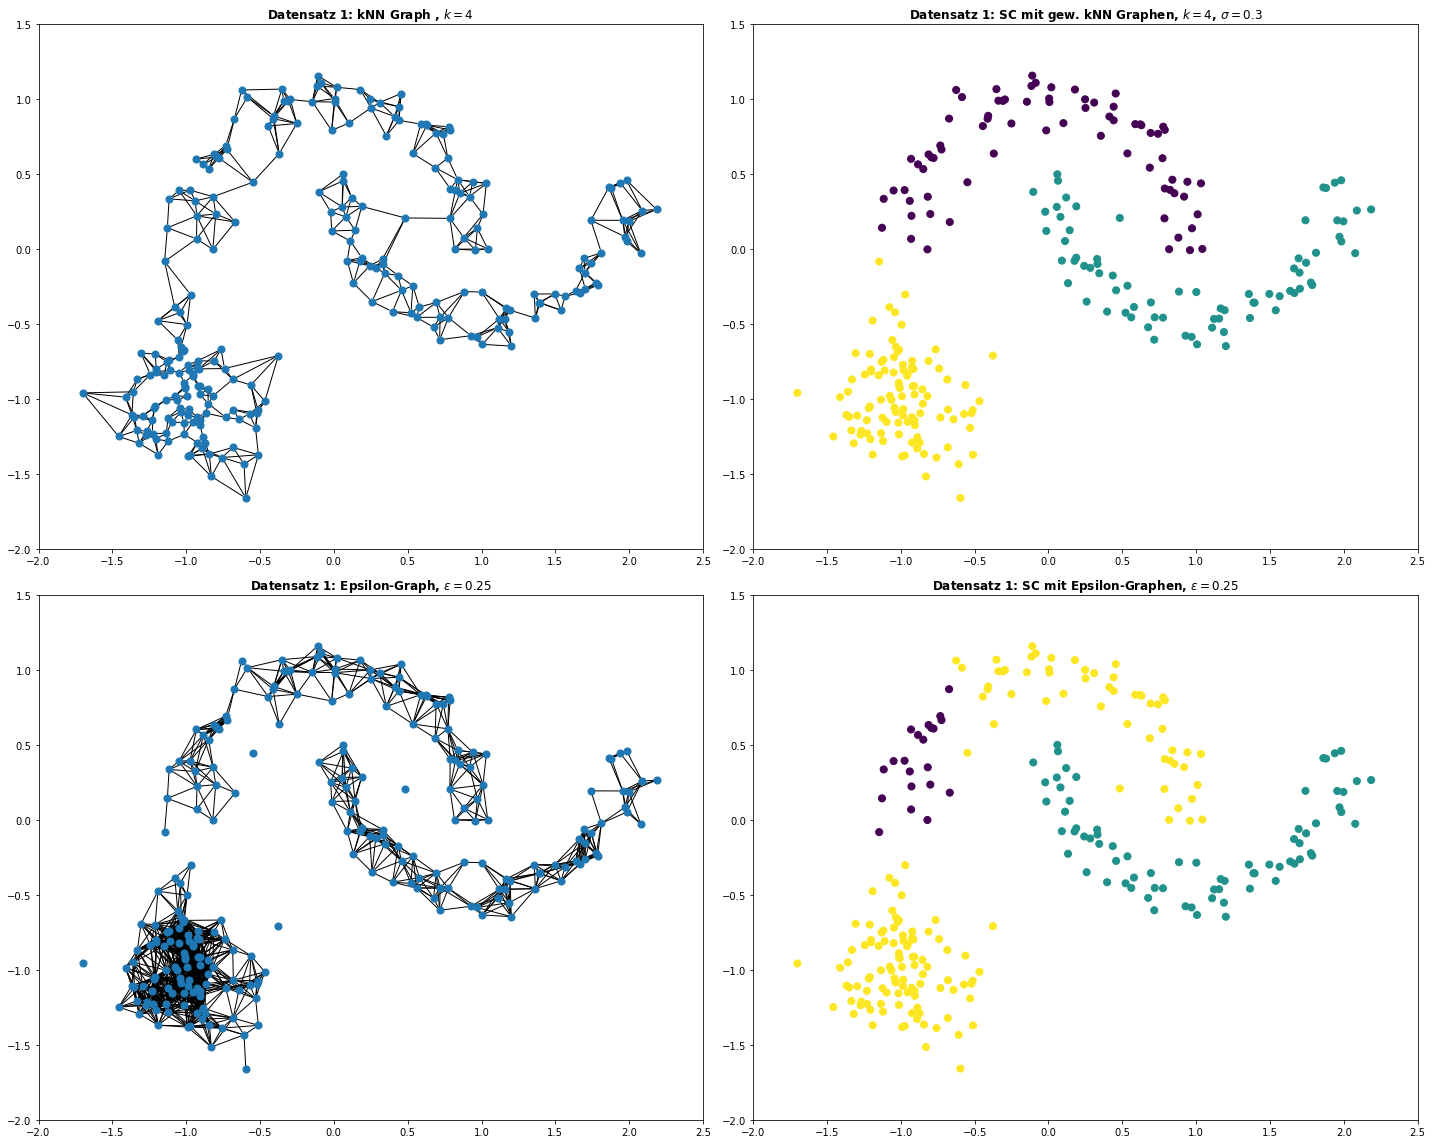

In [27]:
#Finde für gefundene Cluster beste label und bestimme Anzahl der falsch geclusterten Punkte:
anz_falsch_knn_1, Daten_1_knn_1_labels = beste_labelung(Zugehörigkeit_1, Daten_1_knn_1_labels)
anz_falsch_eps_1, Daten_1_eps_1_labels = beste_labelung(Zugehörigkeit_1, Daten_1_eps_1_labels)


print('Beim SC mit dem kNN-Graphen konnten wir', n_1 - anz_falsch_knn_1, 'und mit dem Epsilon-Graphen', 
      n_1 - anz_falsch_eps_1, 'von', n_1, 'Datenpunkten dem Originalen Cluster zuordnen.')


#Plotte die verschiedenen Graphen entsprechendem Clustering

#Erstelle dazu Liste mit Position jedes Knotens in der Ebene. Diese Liste brauchen wir, um die Graphen zu plotten
pos_1= {}
for i in range (n_1):
    pos_1[i] = (Daten_1[i, 0], Daten_1[i, 1])
    



fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,16))

ax[0,0].set_title('Datensatz 1: kNN Graph , $k = 4$', fontsize=12, fontweight='demi')
nx.draw(G_1_knn_1,arrows= True, pos = pos_1,  node_size = 50,ax=ax[0,0] )
ax[0,0].set_axis_on()
ax[0,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0,0].set_xlim([-2, 2.5])
ax[0,0].set_ylim([-2, 1.5])

ax[0,1].set_title('Datensatz 1: SC mit gew. kNN Graphen, $k = 4$, $\sigma =0.3 $', fontsize=12, fontweight='demi')
ax[0,1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 50, c= Daten_1_knn_1_labels , cmap = 'viridis')
ax[0,1].set_axis_on()
ax[0,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0,1].set_xlim([-2, 2.5])
ax[0,1].set_ylim([-2, 1.5])

ax[1,0].set_title('Datensatz 1: Epsilon-Graph, $\epsilon = 0.25$', fontsize=12, fontweight='demi')
nx.draw(G_1_eps_1, pos = pos_1,  node_size = 50,ax=ax[1,0] )
ax[1,0].set_axis_on()
ax[1,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1,0].set_xlim([-2, 2.5])
ax[1,0].set_ylim([-2, 1.5])

ax[1,1].set_title('Datensatz 1: SC mit Epsilon-Graphen, $\epsilon = 0.25$', fontsize=12, fontweight='demi')
ax[1,1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 50, c= Daten_1_eps_1_labels, cmap = 'viridis')
ax[1,1].set_axis_on()
ax[1,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1,1].set_xlim([-2, 2.5])
ax[1,1].set_ylim([-2, 1.5])

fig.tight_layout()


plt.show()

Wir erhalten für den $k$NN-Graphen ein sehr gutes Clusterergebnis. Für den $\epsilon$-Graphen dagegen sehen wir, dass wir $\epsilon$ größer wählen müssen, da der Graph aus zu vielen Komponenten besteht. Das resultierende Clustering ist dementsprechend ausbaufähig.

Deshalb wählen wir nun $\epsilon$, wie von Luxburg vorgeschlagen, als längste Kante eines minimalen Spannbaums des voll verbundenen Graphen. Dazu erstellen wir zunächst eine Funktion, die die Länge einer solchen Kante findet und diese sowie den Spannbaum und dessen Kantenmenge zurückgibt. Diese Funktion wenden wir auf unsere Daten an und wiederholen das Clustering für das neu gefundene $\epsilon$.

Das kleinste Epsilon, für das wir einen zusammenhängenden Graphen erhalten ist:  0.3025119629478944


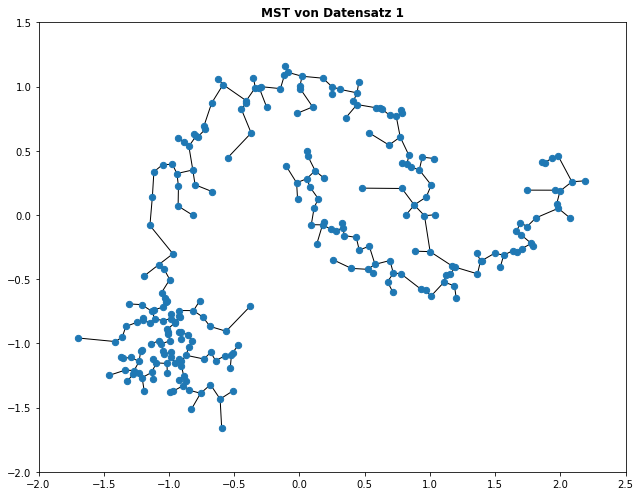

In [14]:
def MST_Methode(Daten):
    A = euclidean_distances(Daten) #paarweise eukl. Distanzen

    #erstelle vollverbundenen Graphen aus Datensatz mit paarweisen Abständen als Gewichten
    G = nx.from_numpy_matrix(A)
    
    #Berechne minimalen Spannbaum mittels Kruskal Algorithmus
    min_spann_baum = nx.tree.minimum_spanning_edges(G, algorithm="kruskal", data=False)
    kantenliste = list(min_spann_baum) #Kanntenmenge des Spannbaums
    
    
    #längste Kante in minimalem Spannbaum
    max = 0
    for kante in kantenliste:
        if A[kante] >= max:
            max = A[kante]
    
    return(max, kantenliste, G)

#epsilon durch MST-Methode
epsilon_2, kantenmenge, G = MST_Methode(Daten_1)

print('Das kleinste Epsilon, für das wir einen zusammenhängenden Graphen erhalten ist: ', epsilon_2)

#Plotte Spannbaum
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('MST von Datensatz 1', fontsize=12, fontweight='demi')
nx.draw(G, pos = pos_1, edgelist =kantenmenge, node_size = 40)
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlim([-2, 2.5])
ax.set_ylim([-2, 1.5])

fig.tight_layout()
plt.show()


Mit epsilon durch die MST-Methode konnten wir 247 von 250 Datenpunkten den originalen Clustern zuordnen.


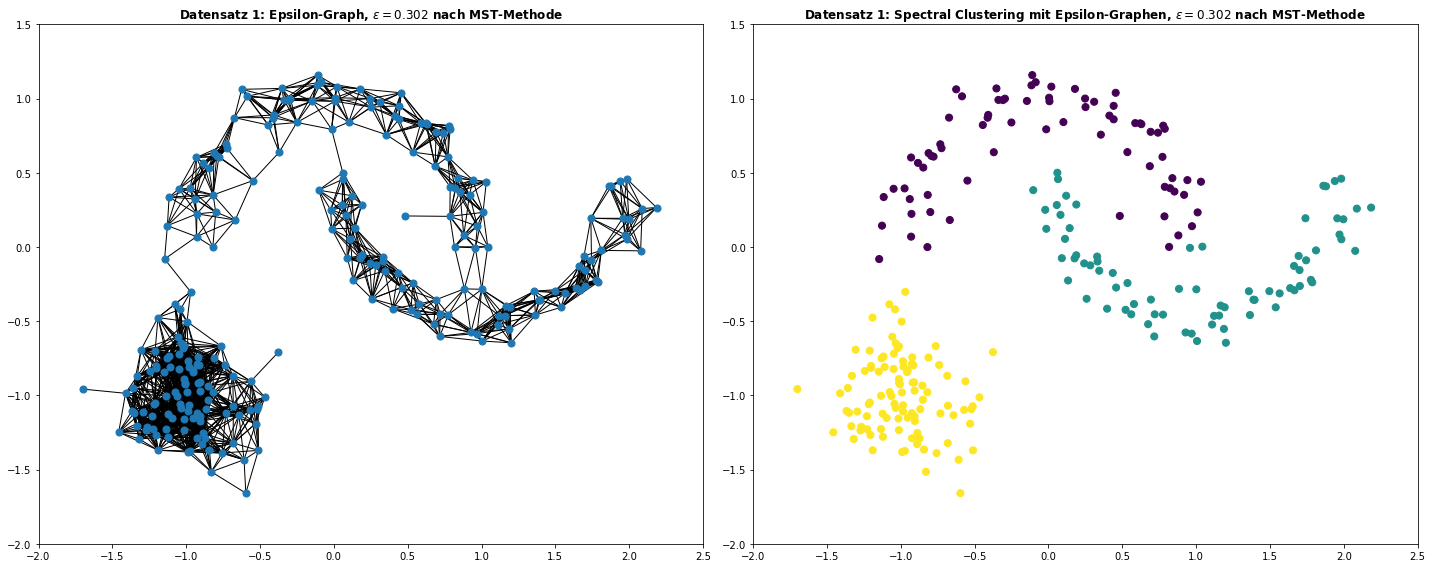

In [28]:
#Graph und Cluserting mit Epsilon durch MST-Methode
G_1_eps_2, Daten_1_eps_2_labels  = SC_eps_Graph (Daten_1, SC_1, epsilon_2)

anz_falsch_eps_2, Daten_1_eps_2_labels = beste_labelung(Zugehörigkeit_1, Daten_1_eps_2_labels)

print('Mit epsilon durch die MST-Methode konnten wir', n_1-anz_falsch_eps_2, 'von', n_1,
      'Datenpunkten den originalen Clustern zuordnen.')


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))


ax[0].set_title('Datensatz 1: Epsilon-Graph, $\epsilon = 0.302$ nach MST-Methode', fontsize=12, fontweight='demi')
nx.draw(G_1_eps_2, pos = pos_1, node_size = 50,ax=ax[0] )
ax[0].set_axis_on()
ax[0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0].set_xlim([-2, 2.5])
ax[0].set_ylim([-2, 1.5])

ax[1].set_title('Datensatz 1: Spectral Clustering mit Epsilon-Graphen, $\epsilon = 0.302$ nach MST-Methode', fontsize=12, fontweight='demi')
ax[1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 50, c= Daten_1_eps_2_labels, cmap = 'viridis')
ax[1].set_axis_on()
ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1].set_xlim([-2, 2.5])
ax[1].set_ylim([-2, 1.5])

fig.tight_layout()

plt.show()

Wie wir sehen, erhalten wir für $\epsilon$ aus der MST-Methode ein gutes Clustering.

Als nächstes betrachten wir als Ähnlichkeitsgraphen den voll-verbundenen Graphen, bei dem wir alle Knoten durch Kanten miteinander verbinden und diese durch Ähnlichkeitswerte $s_{ij}$ gewichten. Die Gewichte erhalten wir durch die Gaußsche Ähnlichkeitsfunktion, also 

\begin{align*}
s_{ij} = \exp\left(\frac{- \, d_{ij}\, ^2}{2\sigma^2} \right)   = \exp\left(\frac{- \| x_i - x_j\| ^2}{2\sigma^2} \right),
\end{align*} 
wobei wir $\sigma$ versuchen werden, geeignet zu wählen. Beim Spectralen Clustering müssen wir dieses mal für den Parameter 'affinity' den Wert 'rbf' wählen, wobei 'rbf' für 'radial basis function' kernel steht. Diese Funktion ist implemeniert als

\begin{align*}
\exp \left(- \gamma \| x_i - x_j\|^2 \right).
\end{align*} 
 
Dies entspricht mit $\gamma = \frac{1}{2 \sigma^2}$ also genau der Definition der Gaußschen Ähnlichkeitsfunktion. Dem Spectralen Clustering Algorithmus übergeben wir einem Wert für $\gamma$, wobei $\gamma \geq 1$ sein muss. Also müssen wir $\sigma \leq \sqrt{\frac{1}{2}}$ wählen.

Als erstes wählen wir $\sigma = \epsilon$ für das $\epsilon$ aus der MST-Methode von oben.

Mit dem voll-verb.- Graphen und sigma = epsilon konnten wir  222 von 250 Datenpunkten den originalen Clustern zuordnen.


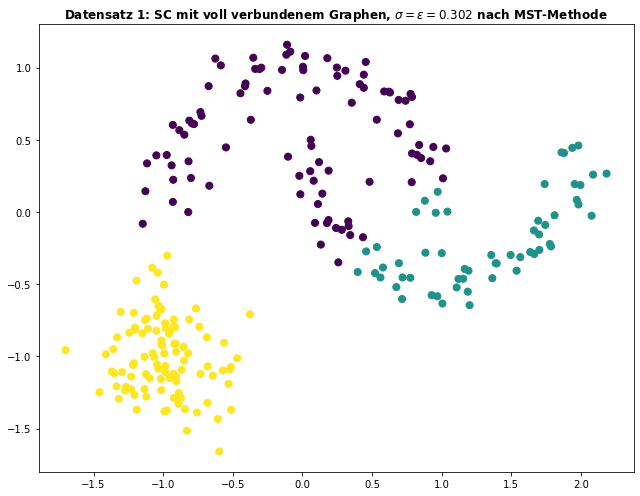

In [29]:
sigma_1 = epsilon_2
gamma_1 = 1/ (2* (sigma_1)**2)

#SC mit vollverbundenem Graphen 
SC_2 = SpectralClustering(n_clusters=3,  gamma=gamma_1, affinity='rbf',  assign_labels='kmeans')
SC_2.fit(Daten_1)

Daten_1_voll_1_labels= SC_2.labels_
anz_falsch_voll_1, Daten_1_voll_1_labels = beste_labelung(Zugehörigkeit_1, Daten_1_voll_1_labels)

print('Mit dem voll-verb.- Graphen und sigma = epsilon konnten wir ', n_1-anz_falsch_voll_1, 'von', n_1,
      'Datenpunkten den originalen Clustern zuordnen.')

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Datensatz 1: SC mit voll verbundenem Graphen, $\sigma = \epsilon = 0.302$ nach MST-Methode', fontsize=12, 
             fontweight='demi')
ax.scatter(Daten_1[:, 0], Daten_1[:, 1], s= 50, c= Daten_1_voll_1_labels, cmap = 'viridis'  )

fig.tight_layout()

plt.show()


Wir sehen, dass für $\sigma = \epsilon $ für den Datensatz nicht optimal ist. Der Spectrale Cluster Algorithmus kann die beiden Monde nicht richtig unterscheiden. Die lässt vermuten, dass Knoten, die "weiter" voneinander entfernt sind, noch ein zu hohes Gewicht haben, also $\sigma$ zu groß gewählt ist. Wir versuchen deshalb im zweiten Versuch, $\sigma$ durch die Mittelwertmethode zu wählen. 

Sigma durch die Mittelwertmethode: 0.1383907797438759
Mit dem voll-verb.- Graphen und sigma durch die Mittelwertmethode konnten wir  250 von 250 Datenpunkten den originalen Clustern zuordnen.


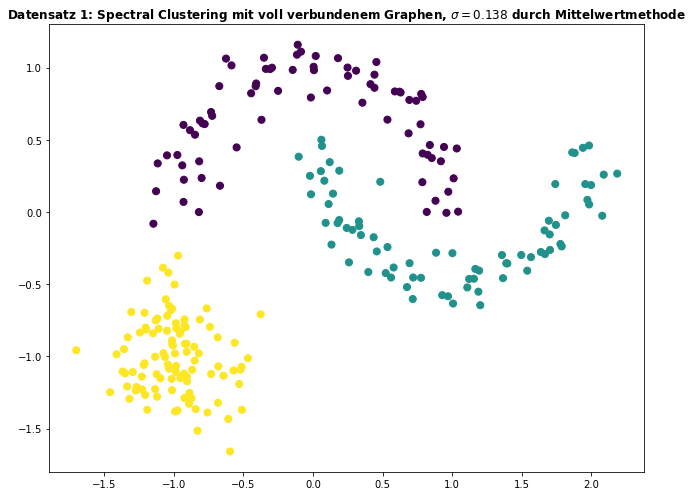

In [30]:
#Mittelwertmethode:
def Mittelwertmethode (Daten, n):
    #Berechne kNN-Matrix mit Distanzen mit k wie oben angegeben
    k = int(np.ceil(np.log(n) +1)) #aufgerundetes k damit k integer
    
    #Adjazenzmatrix für knn-Graphen
    A_1_knn_dis = kneighbors_graph(Daten, n_neighbors=k, mode= 'distance').toarray()
    
    #Mittelwert aller Einträge != 0 für jede Zeile, dies Eentspricht dem mittleren Abstand pro Knoten 
    #zu seinen k nächsten Nachbarn
    zeilen_mittelwert = np.sum(A_1_knn_dis, axis=1) /k 
    
    #mittelwert dieser Abstände
    mittelwert = np.mean(zeilen_mittelwert)
    
    return(mittelwert)



#Anwendung auf Daten:
sigma_2 = Mittelwertmethode(Daten_1, n_1) 

print('Sigma durch die Mittelwertmethode:', sigma_2) #sigma = 0.138

gamma_2 = 1/ (2* (sigma_2)**2)

SC_2 = SpectralClustering(n_clusters=3,  gamma=gamma_2, affinity='rbf',  assign_labels='kmeans')

SC_2.fit(Daten_1)

Daten_1_voll_2_labels= SC_2.labels_
anz_falsch_voll_2, Daten_1_voll_2_labels = beste_labelung(Zugehörigkeit_1, Daten_1_voll_2_labels)

print('Mit dem voll-verb.- Graphen und sigma durch die Mittelwertmethode konnten wir ', n_1-anz_falsch_voll_2, 'von', n_1,
      'Datenpunkten den originalen Clustern zuordnen.')


fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Datensatz 1: Spectral Clustering mit voll verbundenem Graphen, $\sigma = 0.138$ durch Mittelwertmethode', 
             fontsize=12, fontweight='demi')
ax.scatter(Daten_1[:, 0], Daten_1[:, 1], s= 50, c= Daten_1_voll_2_labels, cmap = 'viridis'  )
fig.tight_layout()
plt.show()


Mit diesem $\sigma$ sehen wir, dass das entsprechende Clustering die Monde und den Blob sehr gut voneinander unterscheidet. Wir haben es geschafft, alle Punkte richtig zu clustern.

Dies motiviert das gleiche $\sigma$ und $k$ auch für den $k$NN-Graphen zu benutzen.

Mit dem knn-Graphen und Werten durch die Mittelwertmethode konnten wir  250 von 250 Datenpunkten den originalen Clustern zuordnen.


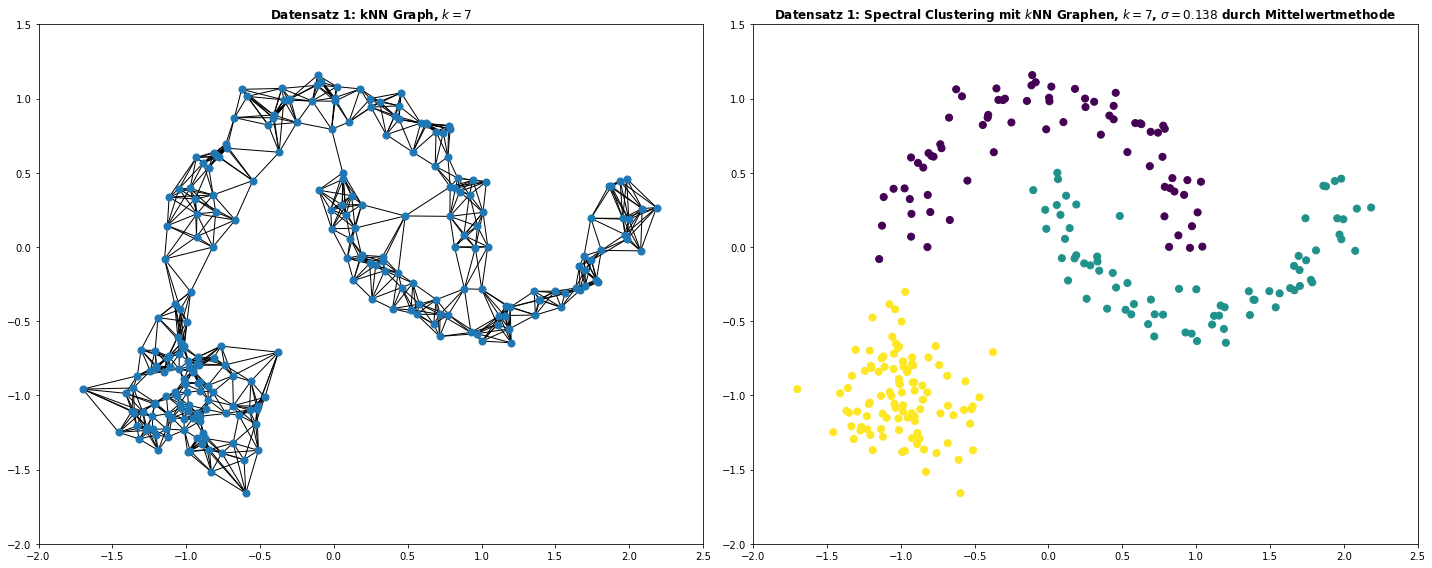

In [31]:
#Erstelle kNN-Graphen für anderes k

k_2 =  int(np.ceil(np.log(n_1) +1)) #k = 7

G_1_knn_2, Daten_1_knn_2_labels = SC_kNN_Graph(Daten_1, SC_1, k = k_2, sigma = sigma_2)

#nehme jene Label, die der tatsächlichen labelung am ähnlichsten ist
anz_falsch_knn_2, Daten_1_knn_2_labels = beste_labelung(Zugehörigkeit_1, Daten_1_knn_2_labels)

print('Mit dem knn-Graphen und Werten durch die Mittelwertmethode konnten wir ', n_1-anz_falsch_knn_2, 'von', n_1,
      'Datenpunkten den originalen Clustern zuordnen.')


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))

ax[0].set_title('Datensatz 1: kNN Graph, $k = 7$', fontsize=12, fontweight='demi')
nx.draw(G_1_knn_2, pos = pos_1, node_size = 50,ax=ax[0] )
ax[0].set_axis_on()
ax[0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[0].set_xlim([-2, 2.5])
ax[0].set_ylim([-2, 1.5])


ax[1].set_title('Datensatz 1: Spectral Clustering mit $k$NN Graphen, $k = 7$, $\sigma = 0.138$ durch Mittelwertmethode', 
                fontsize=12, fontweight='demi')
ax[1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 50, c= Daten_1_knn_2_labels , cmap = 'viridis')
ax[1].set_axis_on()
ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax[1].set_xlim([-2, 2.5])
ax[1].set_ylim([-2, 1.5])

fig.tight_layout()

plt.show()

Wie wir sehen, konnten wir auch hier alle Punkte richtig in die Cluster einteilen, aus denen sie eigentlich stammen. Der $k$NN-Graph hat gegenüber dem voll-verbundenem Graphen den Vorteil, dass die resultierende Ähnlichkeitsmatrix dünn besetzt ist, was gerade bei großen Datenmengen für die numerische Berechnung der Eigenvektoren von großem Vorteil ist.

Zu Schluss wollen wir für diesen Datensatz die verschiedenen Plots in wenigen großen Plots vereinen, um die Ergebnisse in der Arbeit gut darzustellen. Dazu speichern wir die Grafiken als "PGF"-Dateien. Dies hat den Vorteil, dass die Qualität der Grafiken in der Latex, um einiges höher ist, als für "png"-Dateien. Ein Nachteil dagegen ist, dass das Kompilieren in Latex dafür deutlich länger dauern kann. Die unten erzeugten Grafiken entsprechen Abbildung 5 und 7 aus der Arbeit.

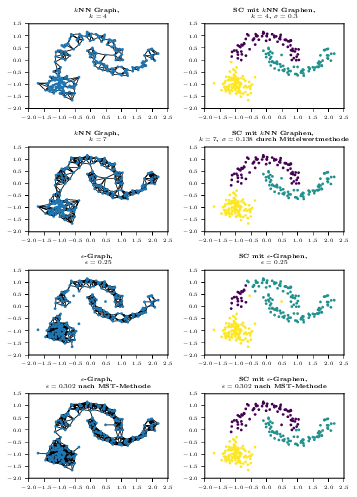

In [34]:

matplotlib.use("pgf")
matplotlib.rcParams.update({
   "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(20,30))



#kNN-Graph mit k = 4
ax[0,0].set_title(' $k$NN Graph, \n $k = 4$', fontsize=6, fontweight='demi')
nx.draw(G_1_knn_1,arrows= True, pos = pos_1, node_size = 2, width= 0.5, ax=ax[0,0] )
ax[0,0].set_axis_on()
ax[0,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[0,0].set_xlim([-2, 2.5])
ax[0,0].set_ylim([-2, 1.5])

ax[0,1].set_title('SC mit $k$NN Graphen,\n $k = 4$, $\sigma =0.3 $', fontsize=6, fontweight='demi')
ax[0,1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 2, c= Daten_1_knn_1_labels , cmap = 'viridis')
ax[0,1].set_axis_on()
ax[0,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[0,1].set_xlim([-2, 2.5])
ax[0,1].set_ylim([-2, 1.5])


#kNN-Graph mit k = 10
ax[1,0].set_title('$k$NN Graph, \n $k = 7$', fontsize=6, fontweight='demi')
nx.draw(G_1_knn_2, pos = pos_1, node_size = 2, width= 0.5, ax=ax[1,0] )
ax[1,0].set_axis_on()
ax[1,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[1,0].set_xlim([-2, 2.5])
ax[1,0].set_ylim([-2, 1.5])

ax[1,1].set_title('SC mit $k$NN Graphen, \n $k = 7$, $\sigma = 0.138$ durch Mittelwertmethode', fontsize=6, fontweight='demi')
ax[1,1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 2, c= Daten_1_knn_2_labels , cmap = 'viridis')
ax[1,1].set_axis_on()
ax[1,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[1,1].set_xlim([-2, 2.5])
ax[1,1].set_ylim([-2, 1.5])


#eps-Graph mit eps = 0.25
ax[2,0].set_title('$\epsilon$-Graph, \n $\epsilon = 0.25$', fontsize=6, fontweight='demi')
nx.draw(G_1_eps_1, pos = pos_1, node_size = 2, width= 0.5, ax=ax[2,0] )
ax[2,0].set_axis_on()
ax[2,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[2,0].set_xlim([-2, 2.5])
ax[2,0].set_ylim([-2, 1.5])

ax[2,1].set_title('SC mit $\epsilon$-Graphen, \n $\epsilon = 0.25$', fontsize=6, fontweight='demi')
ax[2,1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 2, c= Daten_1_eps_1_labels, cmap = 'viridis')
ax[2,1].set_axis_on()
ax[2,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[2,1].set_xlim([-2, 2.5])
ax[2,1].set_ylim([-2, 1.5])




#eps-Graph mit eps aus MST-Methode
ax[3,0].set_title('$\epsilon$-Graph, \n $\epsilon = 0.302$ nach MST-Methode', fontsize=6, fontweight='demi')
nx.draw(G_1_eps_2, pos = pos_1, node_size = 2, width= 0.5, ax=ax[3,0] )
ax[3,0].set_axis_on()
ax[3,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,  labelsize = 4)
ax[3,0].set_xlim([-2, 2.5])
ax[3,0].set_ylim([-2, 1.5])

ax[3,1].set_title('SC mit $\epsilon$-Graphen, \n $\epsilon = 0.302$ nach MST-Methode', fontsize=6, fontweight='demi')
ax[3,1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 2, c= Daten_1_eps_2_labels, cmap = 'viridis')
ax[3,1].set_axis_on()
ax[3,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[3,1].set_xlim([-2, 2.5])
ax[3,1].set_ylim([-2, 1.5])

fig.tight_layout()

fig.set_size_inches(5.04, 7)
fig.tight_layout()

plt.savefig('Daten_1_knn_eps.pgf')

plt.show()

Als nächstes plotten wir jeweils das Clustering der zwei voll verbundenen Graphen für die 2 Parameter von $\sigma$.


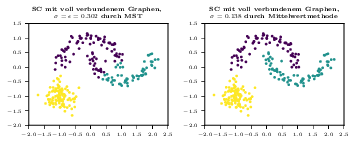

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,8))
ax[0].set_title('SC mit voll verbundenem Graphen, \n $\sigma = \epsilon = 0.302$ durch MST', fontsize=6, fontweight='demi')
ax[0].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 2, c= Daten_1_voll_1_labels, cmap = 'viridis'  )
ax[0].set_axis_on()
ax[0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[0].set_xlim([-2, 2.5])
ax[0].set_ylim([-2, 1.5])


ax[1].set_title('SC mit voll verbundenem Graphen,\n $\sigma = 0.138$ durch Mittelwertmethode', fontsize=6, fontweight='demi')
ax[1].scatter(Daten_1[:, 0], Daten_1[:, 1], s= 2, c= Daten_1_voll_2_labels, cmap = 'viridis'  )
ax[1].set_axis_on()
ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize = 4)
ax[1].set_xlim([-2, 2.5])
ax[1].set_ylim([-2, 1.5])


fig.tight_layout()

fig.set_size_inches(5.04, 2.1)
fig.tight_layout()

plt.savefig('Daten_1_voll_verb.pgf')
plt.show()